In [137]:
import xarray as xr
import glob
import cfgrib

# Ensure cfgrib is installed
try:
    import cfgrib
except ImportError:
    raise ImportError("cfgrib is not installed. Install it using: pip install cfgrib")

# Step 1: Define directory path
grib_dir = "/content/data"

# Step 2: Get all GRIB files in the directory
grib_files = sorted(glob.glob(grib_dir + "/p_*.grib"))

# Step 3: Debugging print statements
print("Found GRIB files:", grib_files)

# Step 4: Open files and check time dimension
ds_list = []
for file in grib_files:
    try:
        ds = xr.open_dataset(file, engine="cfgrib")

        # Print available variables and dimensions
        print(f"Reading {file}:")
        print("Variables:", list(ds.variables))
        print("Dimensions:", ds.dims)

        if "time" not in ds.dims:
            print(f"Warning: 'time' dimension missing in {file}. Skipping.")
        else:
            ds_list.append(ds)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Step 5: Merge datasets if any were successfully opened
if ds_list:
    ds = xr.concat(ds_list, dim="time", combine_attrs="override")
    print("Merged dataset is ready.")
else:
    print("No valid datasets found. Check file paths and content.")


Found GRIB files: ['/content/data/p_1990-99.grib', '/content/data/p_2000-12.grib', '/content/data/p_2013-25.grib']


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Reading /content/data/p_1990-99.grib:
Variables: ['number', 'time', 'step', 'surface', 'latitude', 'longitude', 'valid_time', 'tp']
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 7305, 'step': 12, 'latitude': 32, 'longitude': 5})


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Reading /content/data/p_2000-12.grib:
Variables: ['number', 'time', 'step', 'surface', 'latitude', 'longitude', 'valid_time', 'tp']
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 9499, 'step': 12, 'latitude': 32, 'longitude': 5})


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Reading /content/data/p_2013-25.grib:
Variables: ['number', 'time', 'step', 'surface', 'latitude', 'longitude', 'valid_time', 'tp']
Dimensions: FrozenMappingWarningOnValuesAccess({'time': 8928, 'step': 12, 'latitude': 32, 'longitude': 5})
Merged dataset is ready.


In [138]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
from shapely.geometry import box

print(ds)

<xarray.Dataset> Size: 200MB
Dimensions:     (time: 25732, step: 12, latitude: 32, longitude: 5)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 206kB 1989-12-31T18:00:00 ... 2025-03-2...
  * step        (step) timedelta64[ns] 96B 01:00:00 02:00:00 ... 12:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 256B 7.05 6.8 6.55 6.3 ... -0.2 -0.45 -0.7
  * longitude   (longitude) float64 40B 72.54 72.79 73.04 73.29 73.54
    valid_time  (time, step) datetime64[ns] 2MB 1989-12-31T19:00:00 ... 2025-...
Data variables:
    tp          (time, step, latitude, longitude) float32 198MB nan nan ... nan
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-04-04T15:45 GR

In [139]:
ds.variables

Frozen({'tp': <xarray.Variable (time: 25732, step: 12, latitude: 32, longitude: 5)> Size: 198MB
array([[[[           nan,            nan,            nan,
                     nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan],
         ...,
         [           nan,            nan,            nan,
                     nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan]],

        [[           nan,            nan,            nan,
                     nan,            nan],
         [           nan,            nan,            nan,
                     nan,            nan],
         [           nan,            nan,            nan,
                     n

In [140]:
lon = ds.tp.longitude
lat = ds['tp'].latitude
da = ds.where(ds.tp != -999.) #Remove NaN values

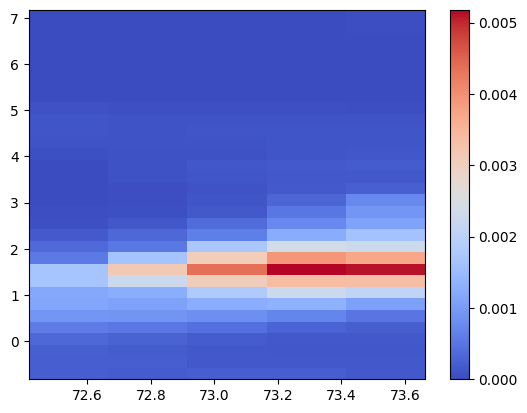

In [141]:
plt.figure()
plt.pcolormesh(lon, lat, ds.tp[255, 0, :, :], shading="auto", cmap="coolwarm")  # Ensure correct slicing
plt.colorbar()
plt.show()


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
<ipython-input-142-d5b0e153e355>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


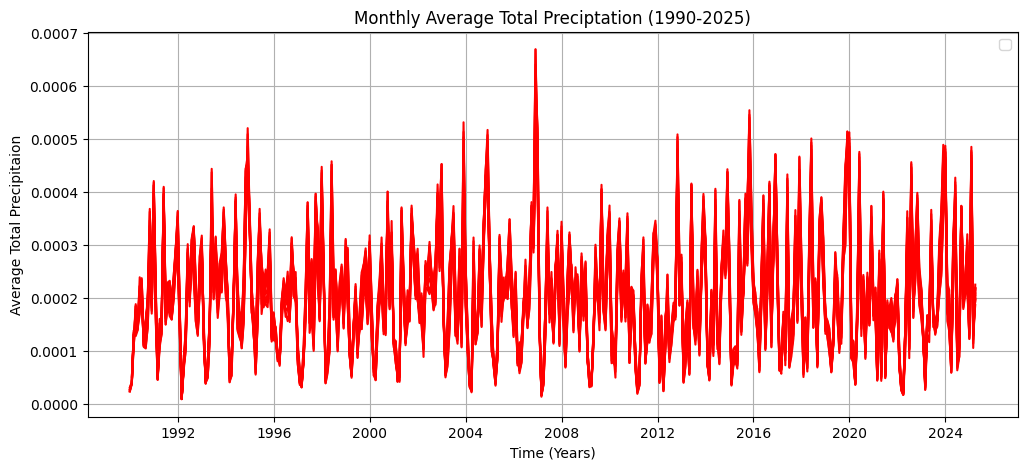

In [142]:
#Monthly average

tp_mean = ds.tp.mean(dim=["latitude", "longitude"])

# Resample to get the monthly average
tp_monthly = tp_mean.resample(time="M").mean()

# Plot the seasonality (monthly averaged precipitation variation)
plt.figure(figsize=(12, 5))
plt.plot(tp_monthly.time, tp_monthly, color='r')

# Formatting the plot
plt.xlabel("Time (Years)")
plt.ylabel("Average Total Precipitaion")
plt.title("Monthly Average Total Preciptation (1990-2025)")
plt.legend()
plt.grid()

# Show the plot
plt.show()

/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
<ipython-input-143-5c7b7a9fce8a>:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


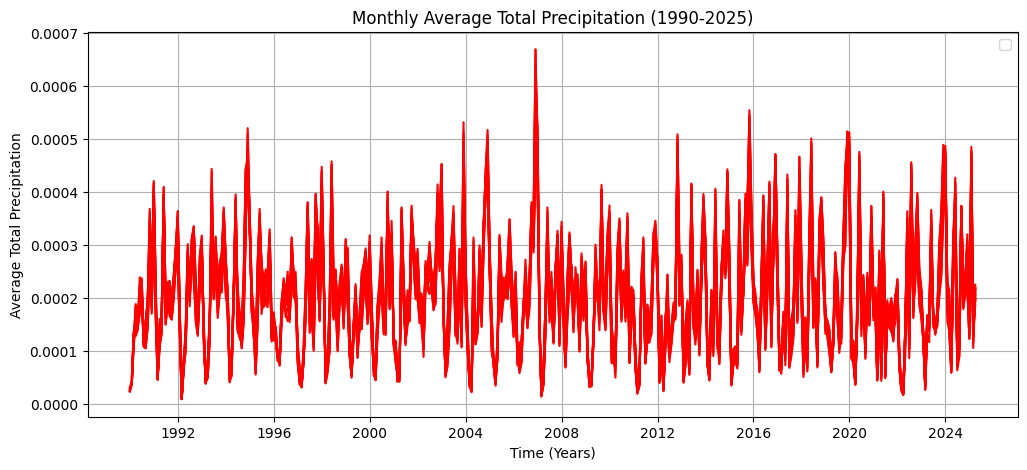

In [143]:


# Compute the spatial mean (assuming "latitude" and "longitude" are the correct names)
tp_mean = ds["tp"].mean(dim=["latitude", "longitude"])

# Ensure valid_time is a coordinate
tp_mean = tp_mean.assign_coords(time=ds["time"])

# Resample to monthly average
tp_monthly = tp_mean.resample(time="M").mean()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(tp_monthly.time, tp_monthly, color='r')

# Formatting
plt.xlabel("Time (Years)")
plt.ylabel("Average Total Precipitation")
plt.title("Monthly Average Total Precipitation (1990-2025)")
plt.legend()
plt.grid()

# Show
plt.show()


In [144]:
print(tp_mean.dims)   # Check dimensions
print(tp_mean.shape)  # Check shape
print(tp_mean.coords) # Check coordinates


('time', 'step')
(25732, 12)
Coordinates:
    number      int64 8B 0
  * step        (step) timedelta64[ns] 96B 01:00:00 02:00:00 ... 12:00:00
    surface     float64 8B 0.0
    valid_time  (time, step) datetime64[ns] 2MB 1989-12-31T19:00:00 ... 2025-...
  * time        (time) datetime64[ns] 206kB 1989-12-31T18:00:00 ... 2025-03-2...


/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


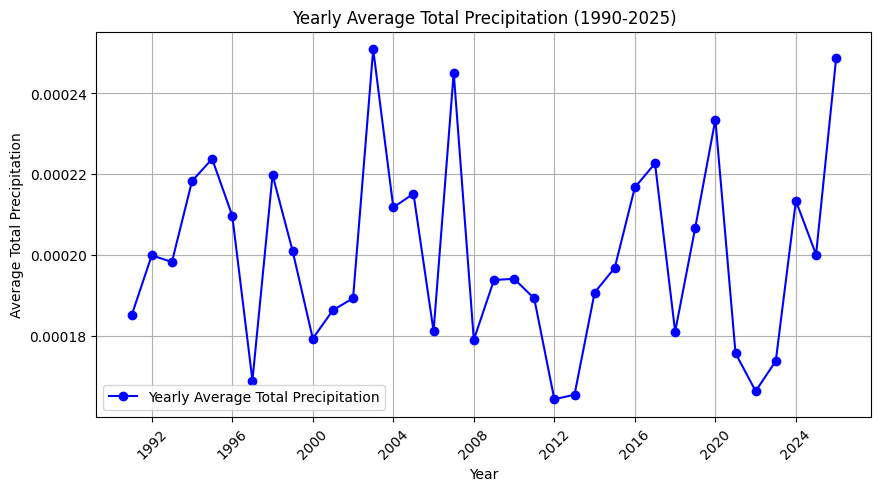

In [145]:
import xarray as xr
import matplotlib.pyplot as plt


# Extract valid time correctly (choosing the first step)
valid_time = ds["valid_time"].isel(step=0)  # Ensure we select one step

# Compute spatial mean
tp_mean = ds["tp"].isel(step=0).mean(dim=["latitude", "longitude"])

# Assign valid_time as the new time index
tp_mean = tp_mean.assign_coords(time=valid_time).swap_dims({"time": "valid_time"})

# Resample to yearly average
tp_yearly = tp_mean.resample(time="Y").mean()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(tp_yearly.time, tp_yearly, marker='o', linestyle='-', color='b', label="Yearly Average Total Precipitation")

plt.xlabel("Year")
plt.ylabel("Average Total Precipitation")
plt.title("Yearly Average Total Precipitation (1990-2025)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


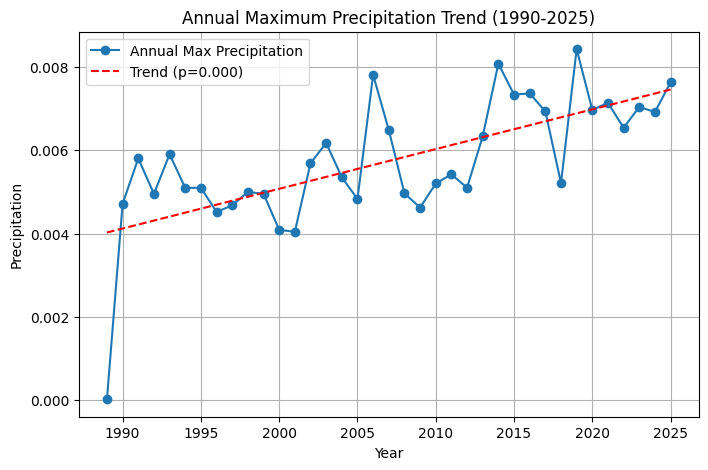

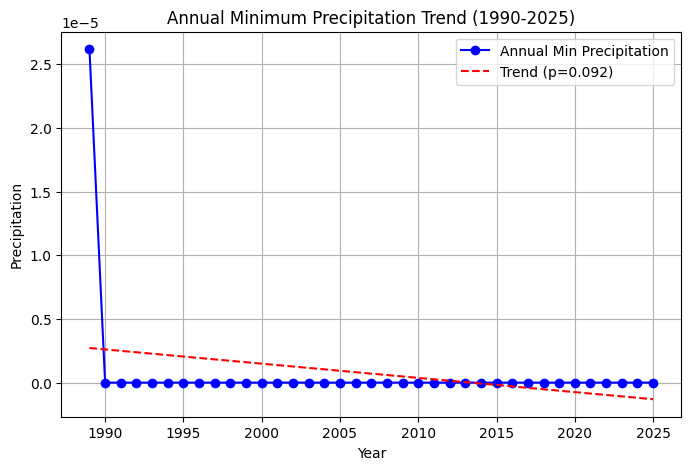

In [146]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Ensure 'valid_time' is a proper datetime object
ds["time"] = xr.decode_cf(ds)["time"]

# Extract the year from the time dimension
ds = ds.assign_coords(year=ds["time"].dt.year)

# Compute annual max and min precipitation (spatially averaged)
annual_max_precipitation = ds.tp.groupby("year").max(dim="time").mean(dim=["latitude", "longitude"])
annual_min_precipitation = ds.tp.groupby("year").min(dim="time").mean(dim=["latitude", "longitude"])

# Convert year coordinate to NumPy array
years = annual_max_precipitation.coords["year"].values

# **Fix: Remove extra dimensions (squeeze)**
annual_max_precipitation = annual_max_precipitation.squeeze()
annual_min_precipitation = annual_min_precipitation.squeeze()

# Ensure they are 1D before regression
if annual_max_precipitation.ndim > 1:
    annual_max_precipitation = annual_max_precipitation.mean(dim="step")  # Adjust if needed
if annual_min_precipitation.ndim > 1:
    annual_min_precipitation = annual_min_precipitation.mean(dim="step")  # Adjust if needed

# Perform linear regression for trends
slope_max, intercept_max, r_value_max, p_value_max, std_err_max = linregress(years, annual_max_precipitation.values)
slope_min, intercept_min, r_value_min, p_value_min, std_err_min = linregress(years, annual_min_precipitation.values)

# Plot the trend for max precipitation
plt.figure(figsize=(8, 5))
plt.plot(years, annual_max_precipitation, marker='o', linestyle='-', label="Annual Max Precipitation")
plt.plot(years, slope_max * years + intercept_max, linestyle="dashed", color="red", label=f"Trend (p={p_value_max:.3f})")
plt.xlabel("Year")
plt.ylabel("Precipitation")
plt.title("Annual Maximum Precipitation Trend (1990-2025)")
plt.legend()
plt.grid()
plt.show()

# Plot the trend for min precipitation
plt.figure(figsize=(8, 5))
plt.plot(years, annual_min_precipitation, marker='o', linestyle='-', label="Annual Min Precipitation", color="blue")
plt.plot(years, slope_min * years + intercept_min, linestyle="dashed", color="red", label=f"Trend (p={p_value_min:.3f})")
plt.xlabel("Year")
plt.ylabel("Precipitation")
plt.title("Annual Minimum Precipitation Trend (1990-2025)")
plt.legend()
plt.grid()
plt.show()


(25732, 32, 5) (25732,)


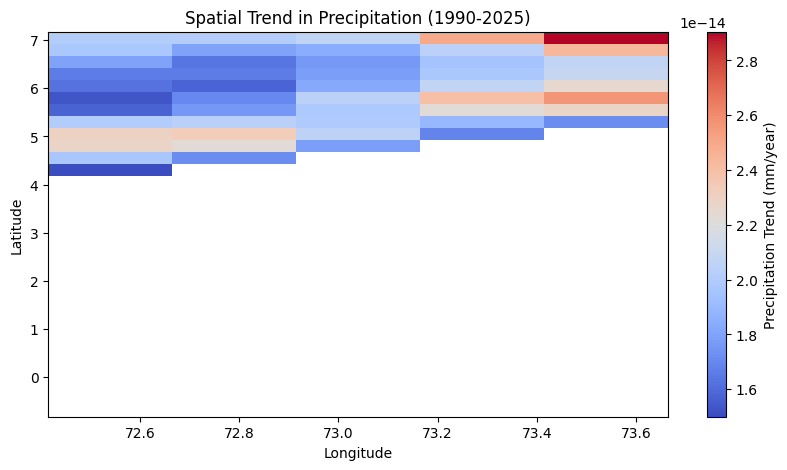

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.interpolate import griddata

# Load dataset

# Extract data
tp = ds.variables["tp"][:]  # Shape: (time, lat, lon)
time = ds.variables["time"][:]
lat = ds.variables["latitude"][:]
lon = ds.variables["longitude"][:]
tp = np.mean(tp, axis=1)
print(tp.shape, time.shape)

# Convert time to years
time = np.array([t.astype('datetime64[Y]').astype(int) + 1970 for t in time])

# Prepare array for storing slopes (precipitation trend at each grid point)
trend_map = np.full((len(lat), len(lon)), np.nan)

# Compute trends for each grid cell
for i in range(len(lat)):
    for j in range(len(lon)):
        precip_series = tp[:, i, j]  # Time series for one grid cell

        if np.all(np.isnan(precip_series)):  # Skip if all values are NaN
            continue

        slope, _, _, p_value, _ = linregress(time, precip_series)

        # Only consider significant trends (p-value < 0.05)
        if p_value < 0.05:
            trend_map[i, j] = slope

# Interpolate missing values
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')
mask = ~np.isnan(trend_map)
points = np.column_stack((lat_grid[mask], lon_grid[mask]))
values = trend_map[mask]
trend_map_interp = griddata(points, values, (lat_grid, lon_grid), method='linear')

# Plot the trend map
plt.figure(figsize=(10, 5))
plt.pcolormesh(lon, lat, trend_map_interp, cmap="coolwarm", shading="nearest")
plt.colorbar(label="Precipitation Trend (mm/year)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Trend in Precipitation (1990-2025)")
plt.show()


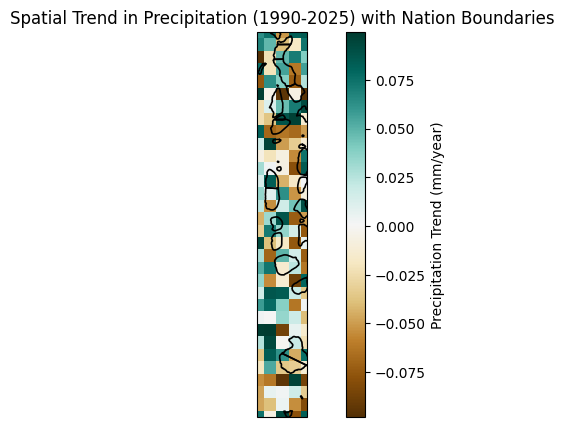

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd

# ---- Step 1: Extract Data from ds ----
tp = ds.variables["tp"][:]  # Extract total precipitation
lat = ds.variables["latitude"][:]
lon = ds.variables["longitude"][:]
time = ds.variables["time"][:]  # If time is needed

# Create a dummy trend map (Replace this with actual trend calculation)
trend_map = np.random.uniform(-0.1, 0.1, (len(lat), len(lon)))  # Fake trends for visualization

# ---- Step 2: Load Country Boundaries ----
shapefile_path = "maldives_admin_division.shp"  # Replace with your shapefile path
gdf = gpd.read_file(shapefile_path)

# Ensure CRS compatibility
if gdf.crs is not None and gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(epsg=4326)

# ---- Step 3: Plot Precipitation Trend with Country Boundaries ----
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot precipitation trend
trend_plot = ax.pcolormesh(lon, lat, trend_map, cmap="BrBG", shading="auto", transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(trend_plot, ax=ax, orientation="vertical", label="Precipitation Trend (mm/year)")

# Plot country boundaries
gdf.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.2, transform=ccrs.PlateCarree())

# Set map extent
ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=ccrs.PlateCarree())

# Labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Spatial Trend in Precipitation (1990-2025) with Nation Boundaries")

# Show plot
plt.show()
